# References
https://geodata.lib.berkeley.edu/catalog/stanford-gn214np6763 (for tanzania polygon)\
https://autogis-site.readthedocs.io/en/latest/notebooks/L1/geometric-objects.html (for handling shape files)\
https://towardsdatascience.com/exploratory-data-analysis-with-pandas-profiling-de3aae2ddff3 (for pandas-profiling)

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 30)
# pd.set_option('display.min_rows', None)
# pd.reset_option(“max_columns”)
pd.reset_option('max_rows')
pd.reset_option('min_rows')

import json
# import seaborn as sns
import numpy as np
from shapely.geometry import Point, shape, LineString, Polygon
import folium
import matplotlib.pyplot as plt

# from pandas_profiling import ProfileReport


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score

Tanzania_coord = (-6.3690,34.8888)


# sns.set(rc={'figure.figsize':(11,8)})

In [2]:
def colInfo(col):
    len_Col = col.shape[0]
    num_zeroes = (col == 0).sum()
    num_missing = col.isna().sum()
    mean = 0
    median = 0
    uniques = len(col.unique())
    try:
        num_unknowns = ((col.str.lower() == 'unknown') | (
            col.str.lower() == ' ') | (col.str.lower() == '')).sum()
    except:
        num_unknowns = 0

    try:
        mean = col.mean()
        median = col.median()
    except:
        mean = 0
        median = 0

    data = [
        ['Zeroes',  f'{num_zeroes:,}',  f'{(num_zeroes/len_Col *100):.2f} %'],
        ['Missing', f'{num_missing:,}',  f'{(num_missing/len_Col *100):.2f} %'],
        ['Unknown', f'{num_unknowns:,}',
            f'{(num_unknowns/len_Col *100):.2f} %'],
        ['Uniques', f'{uniques:,}', f'{(uniques/len_Col *100):.2f} %'],
        ['Mean', f'{mean:.2f}', '-'],
        ['Median', f'{median:.2f}', '-'],
    ]
    info_table = pd.DataFrame(
        data, columns=['', 'Number', 'Percentage']).set_index('').style.set_caption("Table Info")
    display(info_table)
    
    vCountNum = col.value_counts()
    vCountPct = col.value_counts(normalize=True)*100
    vCountNum.name = 'Value Count'
    vCountPct.name = '% Value Count'
     
    value_count_table = pd.concat([vCountNum,vCountPct], axis=1)
    value_count_table = value_count_table.iloc[:10].style.set_caption("Top 10 Value Count Info")
    display(value_count_table)

    if col.dtype == 'float64':
        fig, ax = plt.subplots(figsize=(15, 8))
        plt.plot(col)
        plt.axhline(y=mean, color='r', linestyle='-.', label='Mean')
        plt.axhline(y=median, color='b', linestyle='-.', label='Median')
        plt.title('Bar plot: '+col.name)
        plt.legend()
        plt.ylabel(col.name)

    elif col.dtype == 'int64':
        fig, ax = plt.subplots(figsize=(15, 8))
        plt.hist(col)
        plt.title('Histogram plot: '+col.name)
        plt.ylabel(col.name)
        
        if len(col.value_counts()) < 30:
            fig, ax = plt.subplots(figsize=(15, 8))
            col.value_counts().iloc[:10].plot(kind='bar')
            plt.title('Frequency of top 10: '+col.name)
            plt.ylabel(col.name)
    
    elif col.dtype == 'O':
        fig, ax = plt.subplots(figsize=(15, 8))
        col.value_counts().iloc[:10].plot(kind='bar')
        plt.title('Frequency of top 10: '+col.name)
        plt.ylabel(col.name)
        
        if len(col.value_counts()) > 15:
            fig, ax = plt.subplots(figsize=(15, 8))
            col.value_counts().iloc[-5:].plot(kind='bar')
            plt.title('Frequency of bottom 5: '+col.name)
            plt.ylabel(col.name)

In [3]:
X_train_raw = pd.read_csv('data/Training_set.csv')
y_train_raw = pd.read_csv('data/Training_labels.csv')

X_test_raw = pd.read_csv('data/Test_set.csv')

df_train = pd.merge(X_train_raw,y_train_raw,on='id')

In [4]:
df_train.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

'functional needs repair' will probably need smoting

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [6]:
df_train.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

# Column Analysis

### ID
Too unique and spread. No good for prediction. **Drop**

,Number,Percentage
,,
Zeroes,1,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,"59,400",100.00 %
Mean,37115.13,-
Median,37061.50,-


,Value Count,% Value Count
2047,1,0.001684
72310,1,0.001684
49805,1,0.001684
51852,1,0.001684
62091,1,0.001684
64138,1,0.001684
57993,1,0.001684
60040,1,0.001684
33413,1,0.001684
35460,1,0.001684


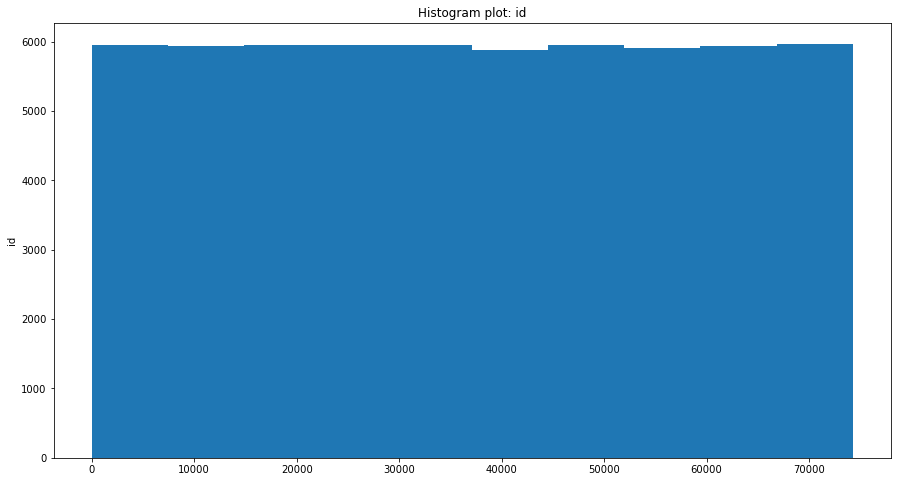

In [7]:
colInfo(df_train.id)

### amount_tsh

,Number,Percentage
,,
Zeroes,"41,639",70.10 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,98,0.16 %
Mean,317.65,-
Median,0.00,-


,Value Count,% Value Count
0.0,41639,70.099327
500.0,3102,5.222222
50.0,2472,4.161616
1000.0,1488,2.505051
20.0,1463,2.462963
200.0,1220,2.053872
100.0,816,1.373737
10.0,806,1.356902
30.0,743,1.250842
2000.0,704,1.185185


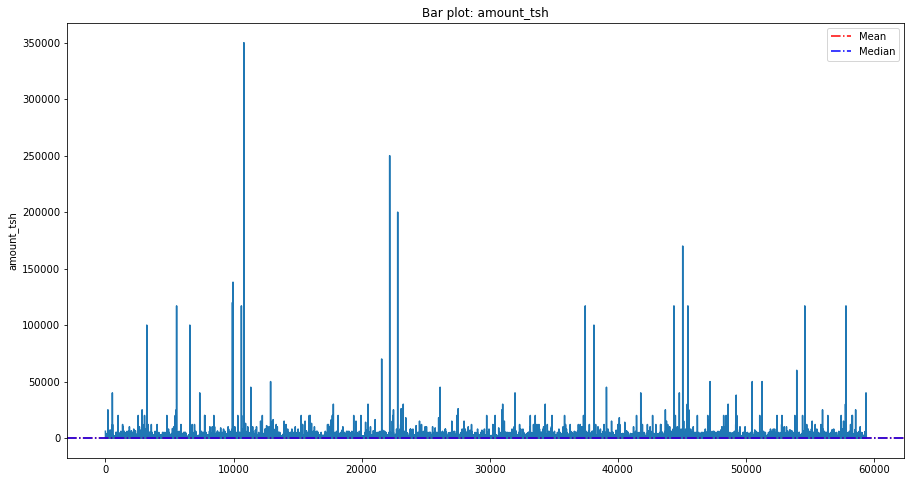

In [8]:
colInfo(df_train.amount_tsh)

skewed. 70% zeros. **Drop**

### funder

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,"3,635",6.12 %
Unknown,4,0.01 %
Uniques,"1,898",3.20 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
Government Of Tanzania,9084,16.289788
Danida,3114,5.584148
Hesawa,2202,3.948713
Rwssp,1374,2.463911
World Bank,1349,2.419080
Kkkt,1287,2.307899
World Vision,1246,2.234376
Unicef,1057,1.895454
Tasaf,877,1.572671
District Council,843,1.511701


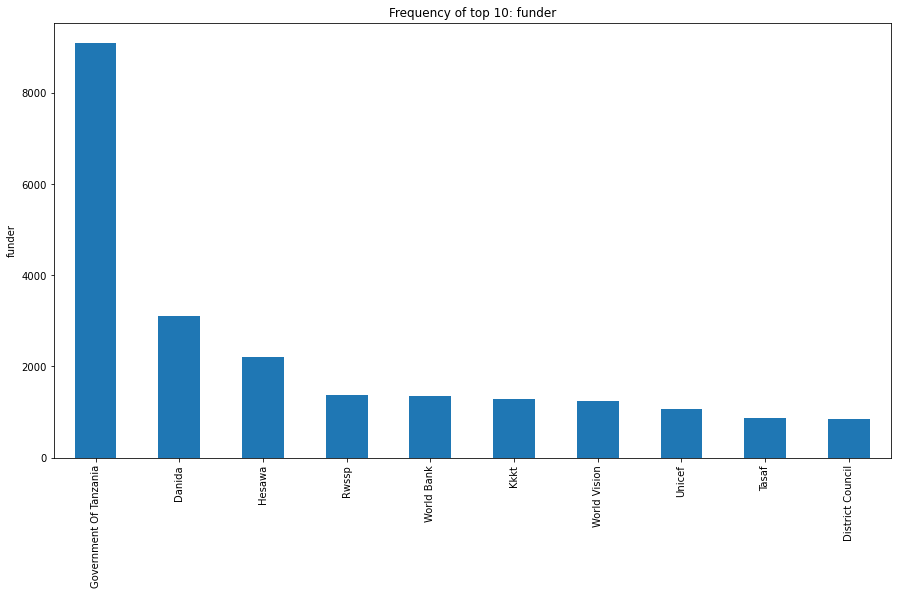

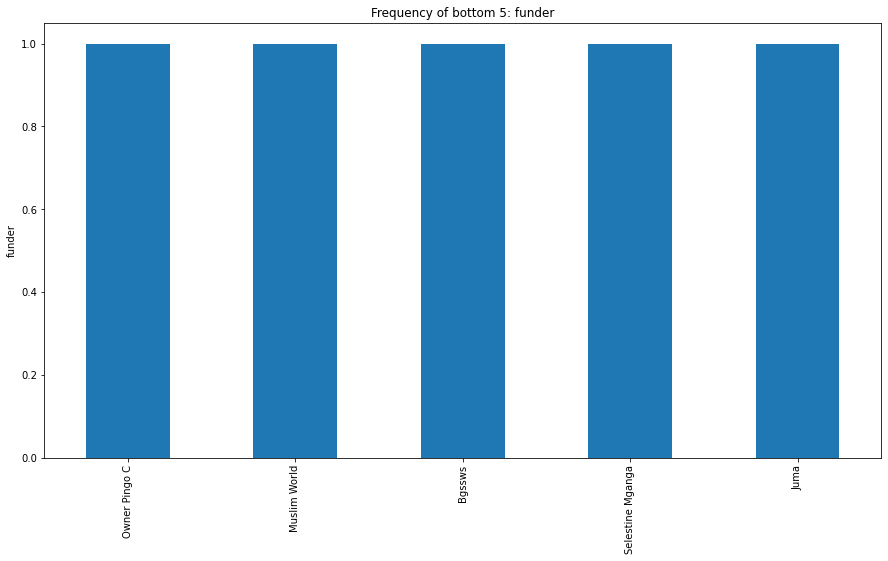

In [9]:
colInfo(df_train.funder)

Missing 6% of data. Most frequent value is 16% of dataframe. 2nd is 5%.

1897 unique labels. **Drop**

### gps_height

,Number,Percentage
,,
Zeroes,"20,438",34.41 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,"2,428",4.09 %
Mean,668.30,-
Median,369.00,-


,Value Count,% Value Count
0,20438,34.407407
-15,60,0.101010
-16,55,0.092593
-13,55,0.092593
-20,52,0.087542
1290,52,0.087542
-14,51,0.085859
303,51,0.085859
-18,49,0.082492
-19,47,0.079125


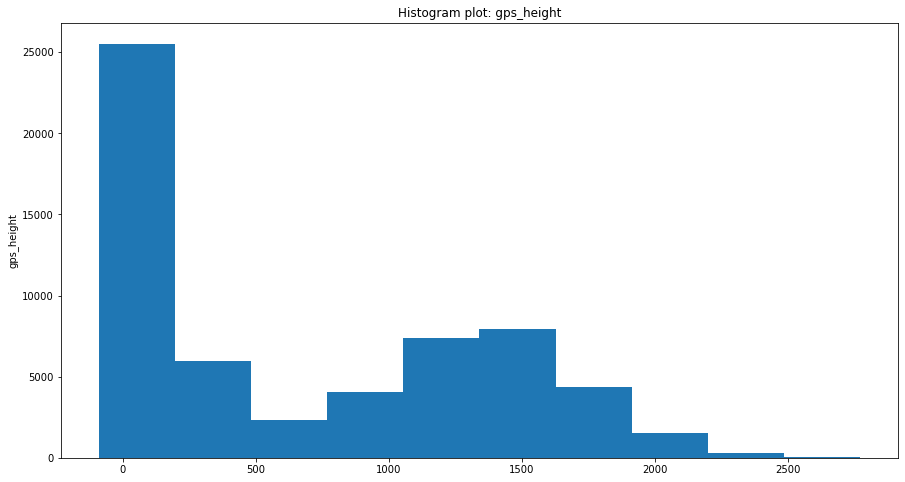

In [10]:
colInfo(df_train.gps_height)

34% is zero. Valid values?

In [11]:
(df_train.gps_height<0).sum()/df_train.shape[0]

0.025185185185185185

2.5% of gps_height is negative. 0 sounds like a valid value. Lakes?

### installer

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,"3,655",6.15 %
Unknown,4,0.01 %
Uniques,"2,146",3.61 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
DWE,17402,31.217150
Government,1825,3.273836
RWE,1206,2.163423
Commu,1060,1.901516
DANIDA,1050,1.883577
KKKT,898,1.610907
Hesawa,840,1.506862
0,777,1.393847
TCRS,707,1.268275
Central government,622,1.115795


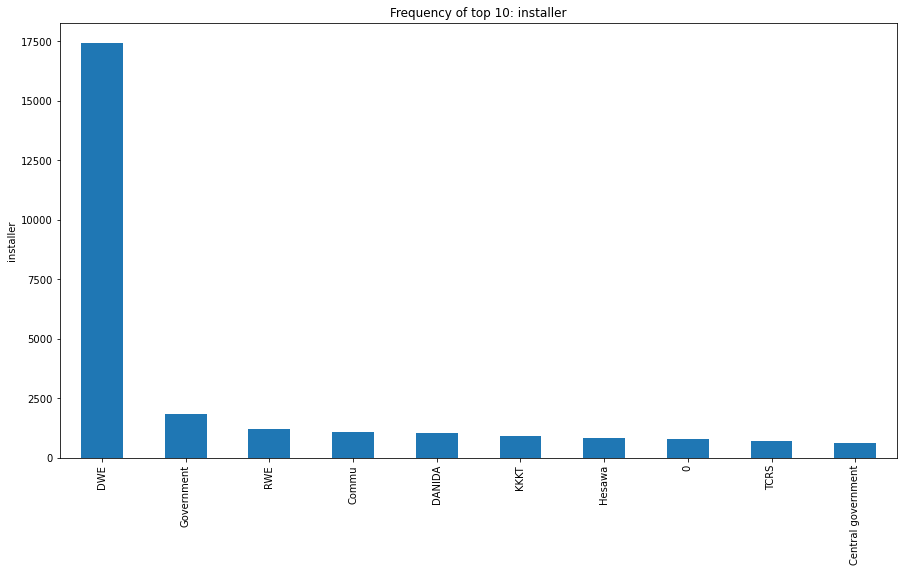

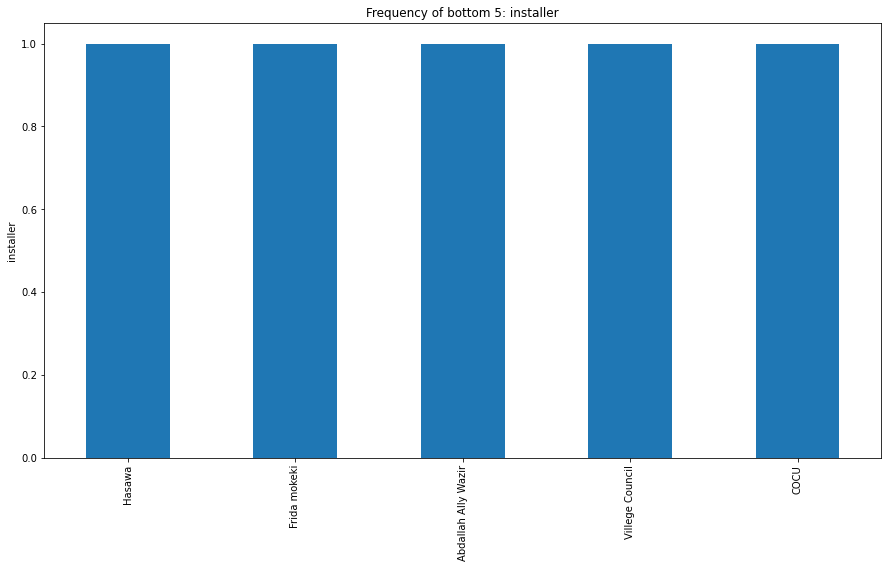

In [12]:
colInfo(df_train.installer)

2145 unique installers. No good way to bin it. OHE -> 2100 new columns to manage. **Drop**

### latitude & longitude

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,"57,517",96.83 %
Mean,-5.71,-
Median,-5.02,-


,Value Count,% Value Count
-2e-08,1812,3.050505
-6.98584173,2,0.003367
-3.79757861,2,0.003367
-6.98188419,2,0.003367
-7.10462503,2,0.003367
-7.05692253,2,0.003367
-7.17517443,2,0.003367
-6.99073094,2,0.003367
-6.978755499999999,2,0.003367
-6.99470401,2,0.003367


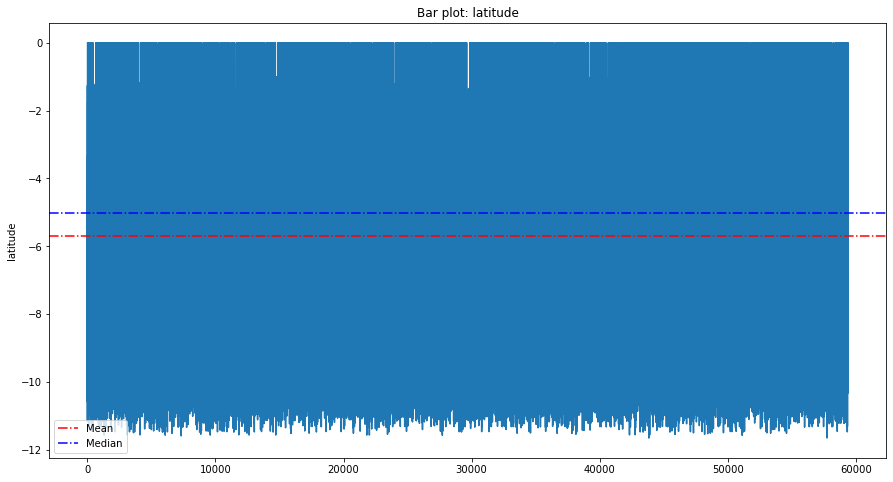

In [13]:
colInfo(df_train.latitude)

,Number,Percentage
,,
Zeroes,"1,812",3.05 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,"57,516",96.83 %
Mean,34.08,-
Median,34.91,-


,Value Count,% Value Count
0.0,1812,3.050505
37.54090064,2,0.003367
33.01050977,2,0.003367
39.09348389,2,0.003367
32.972718699999994,2,0.003367
33.00627548,2,0.003367
39.10395018,2,0.003367
37.54278497,2,0.003367
36.80248988,2,0.003367
39.09837398,2,0.003367


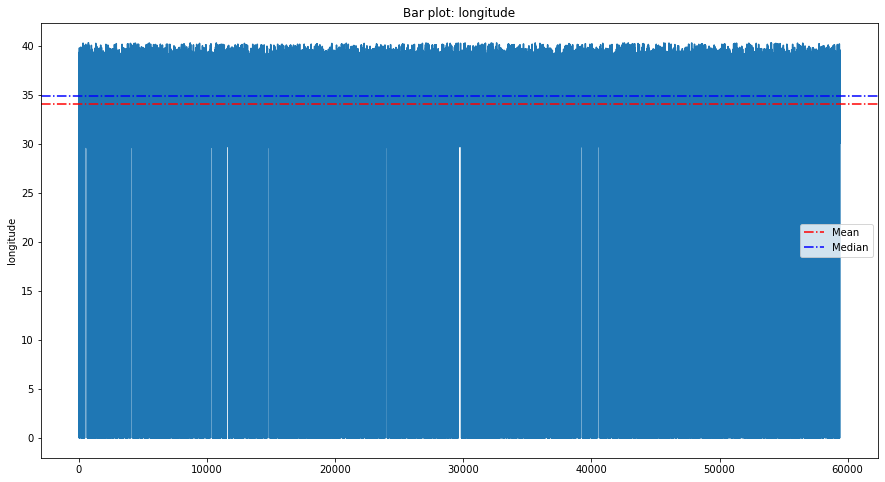

In [14]:
colInfo(df_train.longitude)

In [15]:
df_train[['latitude','longitude']].value_counts()

latitude       longitude
-2.000000e-08  0.000000     1812
-6.975594e+00  39.105307       2
-6.978755e+00  39.093095       2
-7.056372e+00  37.375717       2
-6.978322e+00  39.091380       2
                            ... 
-3.907296e+00  32.899728       1
-3.907373e+00  33.219401       1
-3.907444e+00  33.216340       1
-3.907677e+00  33.189506       1
-1.164944e+01  37.351138       1
Length: 57520, dtype: int64

In [16]:
df_train[['latitude','longitude']].value_counts(normalize=True)

latitude       longitude
-2.000000e-08  0.000000     0.030505
-6.975594e+00  39.105307    0.000034
-6.978755e+00  39.093095    0.000034
-7.056372e+00  37.375717    0.000034
-6.978322e+00  39.091380    0.000034
                              ...   
-3.907296e+00  32.899728    0.000017
-3.907373e+00  33.219401    0.000017
-3.907444e+00  33.216340    0.000017
-3.907677e+00  33.189506    0.000017
-1.164944e+01  37.351138    0.000017
Length: 57520, dtype: float64

There are 1812 (3%) entries with coordinates off the west coast of Africa

In [ ]:
m=folium.Map(location=Tanzania_coord, zoom_start=4, tiles='CartoDB positron')

with open('data/stanford-gn214np6763-geojson_nationalBoundary.json', 'r',encoding='utf8') as f:
    geoJSON_raw = json.load(f)

geo_j = folium.GeoJson(data=geoJSON_raw,
                           style_function=lambda x: {'fillColor': 'orange'})
geo_j.add_to(m)


folium.Marker(
    location=(0,-2e-08),
    icon=folium.Icon(color="blue",icon="tint", prefix='fa')
).add_to(m)

m

Fairly certain these are incorrect entries

In [18]:
df_train.loc[(abs(df_train.longitude) <0.05) & (abs(df_train.latitude) <0.05)].region.unique()

array(['Shinyanga', 'Mwanza'], dtype=object)

All 1812 lie within these 2 regions

In [19]:
df_Mwanza_ignore0Long=df_train[df_train.region=='Mwanza'].loc[df_train.longitude>0]
df_Mwanza_ignore0Long[['latitude','longitude']].describe()

,latitude,longitude
count,2295.000000,2295.000000
mean,-2.620502,33.091564
std,0.329898,0.329287
min,-3.424444,32.046458
25%,-2.847182,32.943112
50%,-2.634751,33.081836
75%,-2.476632,33.345810
max,-1.714486,33.756895


In [ ]:
m=folium.Map(location=(df_Mwanza_ignore0Long['latitude'].median(),df_Mwanza_ignore0Long['longitude'].median()), 
             zoom_start=8, 
             tiles='CartoDB positron')

with open('data/stanford-gn214np6763-geojson_nationalBoundary.json', 'r',encoding='utf8') as f:
    geoJSON_raw = json.load(f)

geo_j = folium.GeoJson(data=geoJSON_raw,
                           style_function=lambda x: {'fillColor': 'orange'})
geo_j.add_to(m)



# Draw region in which Mwanza water wells are in the dataset
folium.Rectangle([(df_Mwanza_ignore0Long['latitude'].min(),df_Mwanza_ignore0Long['longitude'].min()), 
                  (df_Mwanza_ignore0Long['latitude'].max(),df_Mwanza_ignore0Long['longitude'].max())]).add_to(m)

#Dropping a pin of the median lat and median logitude water well
folium.Marker(
        location=(df_Mwanza_ignore0Long['latitude'].median(),df_Mwanza_ignore0Long['longitude'].median()),
        icon=folium.Icon(color="blue",icon="tint", prefix='fa')
    ).add_to(m)
m

In [21]:
df_Shinyanga_ignore0Long=df_train[df_train.region=='Shinyanga'].loc[df_train.longitude>0]
df_Shinyanga_ignore0Long[['latitude','longitude']].describe()

,latitude,longitude
count,3977.000000,3977.000000
mean,-3.495696,33.240121
std,0.328573,0.765545
min,-4.381946,31.454726
25%,-3.768391,32.535525
50%,-3.499209,33.437223
75%,-3.229457,33.860597
max,-2.823028,34.758734


In [ ]:
m=folium.Map(location=(df_Shinyanga_ignore0Long['latitude'].median(),df_Shinyanga_ignore0Long['longitude'].median()), 
             zoom_start=8, 
             tiles='CartoDB positron')

with open('data/stanford-gn214np6763-geojson_nationalBoundary.json', 'r',encoding='utf8') as f:
    geoJSON_raw = json.load(f)

geo_j = folium.GeoJson(data=geoJSON_raw,
                           style_function=lambda x: {'fillColor': 'orange'})
geo_j.add_to(m)



# Draw region in which Mwanza water wells are in the dataset
folium.Rectangle([(df_Shinyanga_ignore0Long['latitude'].min(),df_Shinyanga_ignore0Long['longitude'].min()), 
                  (df_Shinyanga_ignore0Long['latitude'].max(),df_Shinyanga_ignore0Long['longitude'].max())]).add_to(m)

#Dropping a pin of the median lat and median logitude water well
folium.Marker(
        location=(df_Shinyanga_ignore0Long['latitude'].median(),df_Shinyanga_ignore0Long['longitude'].median()),
        icon=folium.Icon(color="blue",icon="tint", prefix='fa')
    ).add_to(m)
m

Going to **impute** the median latitude and longitude for waterwells at coordinates 0,0 grouped by the Mwanza and Shinyanga region

### wpt_name

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,3,0.01 %
Uniques,"37,400",62.96 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
none,3563,5.998316
Shuleni,1748,2.942761
Zahanati,830,1.397306
Msikitini,535,0.900673
Kanisani,323,0.543771
Bombani,271,0.456229
Sokoni,260,0.437710
Ofisini,254,0.427609
School,208,0.350168
Shule Ya Msingi,199,0.335017


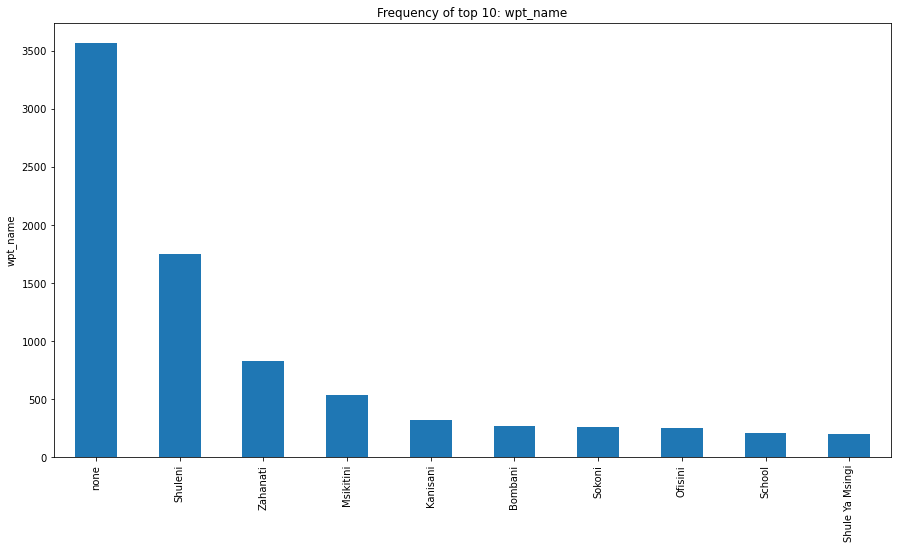

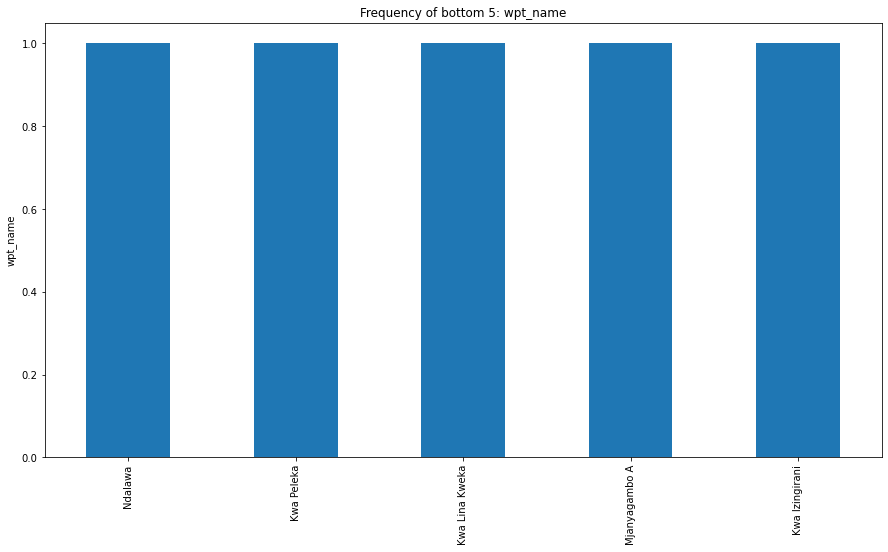

In [23]:
colInfo(df_train.wpt_name)

37000 distinct values. too spread out. **Drop**

### num_private

,Number,Percentage
,,
Zeroes,"58,643",98.73 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,65,0.11 %
Mean,0.47,-
Median,0.00,-


,Value Count,% Value Count
0,58643,98.725589
6,81,0.136364
1,73,0.122896
5,46,0.077441
8,46,0.077441
32,40,0.067340
45,36,0.060606
15,35,0.058923
39,30,0.050505
93,28,0.047138


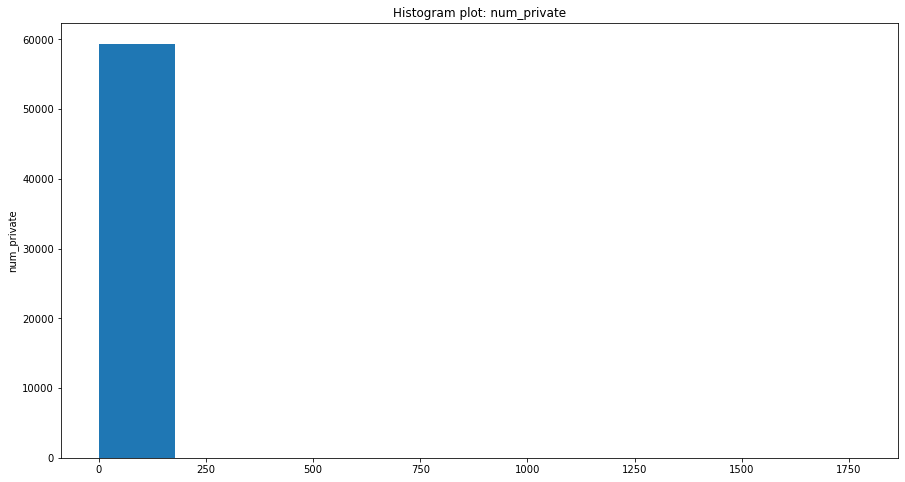

In [24]:
colInfo(df_train.num_private)

*Heavily* skewed. 98.7% zeroes. Next closest value at 0.1%.  **Drop**

### basin

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,9,0.02 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
Lake Victoria,10248,17.252525
Pangani,8940,15.050505
Rufiji,7976,13.427609
Internal,7785,13.106061
Lake Tanganyika,6432,10.828283
Wami / Ruvu,5987,10.079125
Lake Nyasa,5085,8.560606
Ruvuma / Southern Coast,4493,7.563973
Lake Rukwa,2454,4.131313


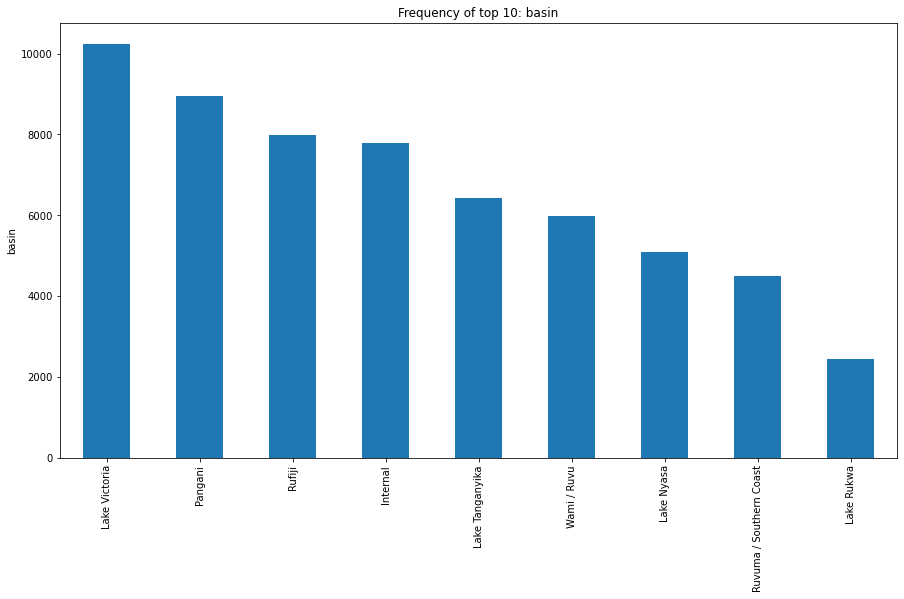

In [25]:
colInfo(df_train.basin)

Perfect. **OHE**

### sub-village

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,371,0.62 %
Unknown,0,0.00 %
Uniques,"19,288",32.47 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
Madukani,508,0.860594
Shuleni,506,0.857206
Majengo,502,0.850429
Kati,373,0.631893
Mtakuja,262,0.443850
Sokoni,232,0.393027
M,187,0.316793
Muungano,172,0.291382
Mbuyuni,164,0.277830
Mlimani,152,0.257501


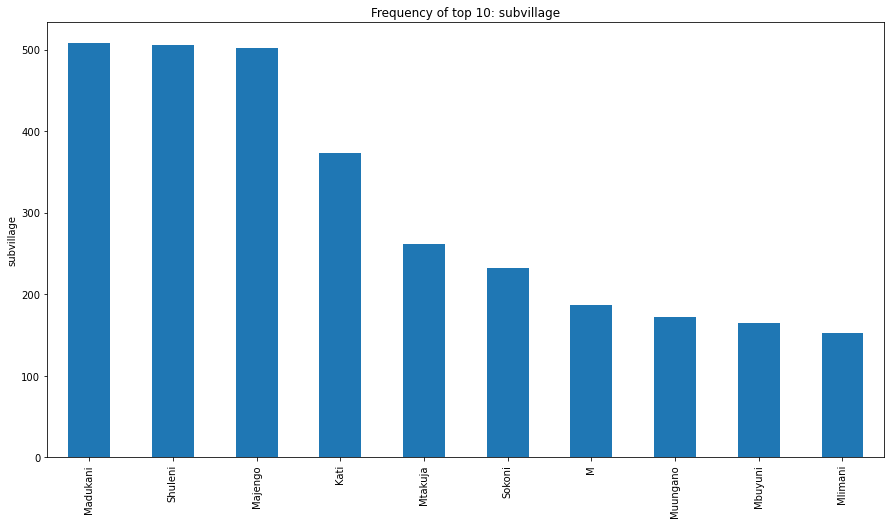

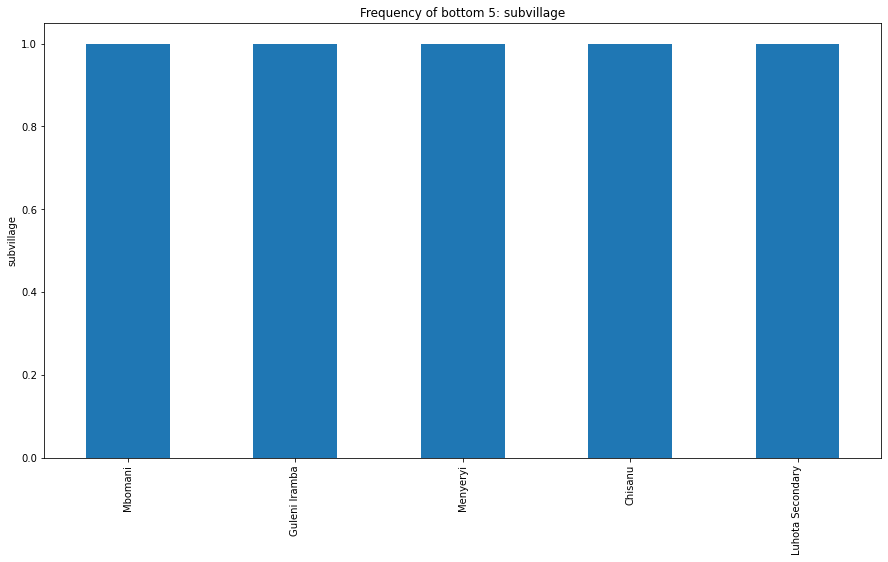

In [26]:
colInfo(df_train.subvillage)

19k distinct values. **drop**

### Region & Region Code

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,21,0.04 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
Iringa,5294,8.912458
Shinyanga,4982,8.387205
Mbeya,4639,7.809764
Kilimanjaro,4379,7.372054
Morogoro,4006,6.744108
Arusha,3350,5.639731
Kagera,3316,5.582492
Mwanza,3102,5.222222
Kigoma,2816,4.740741
Ruvuma,2640,4.444444


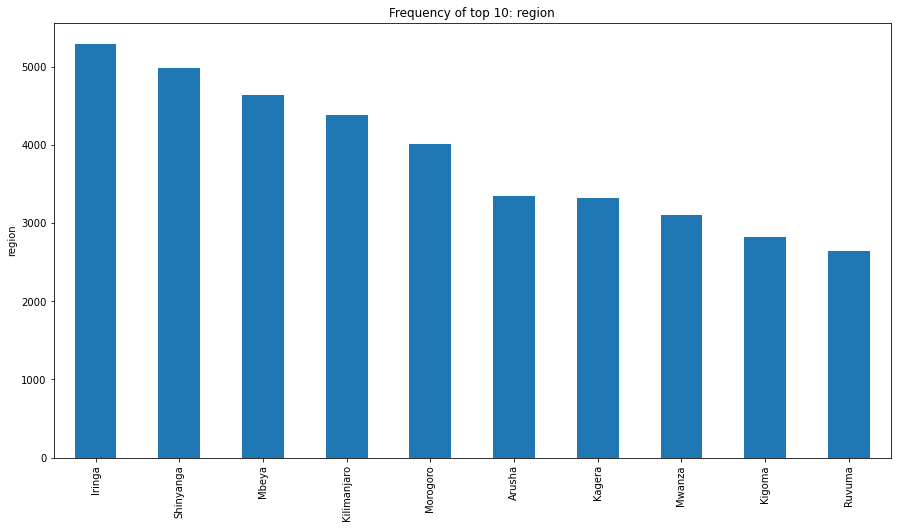

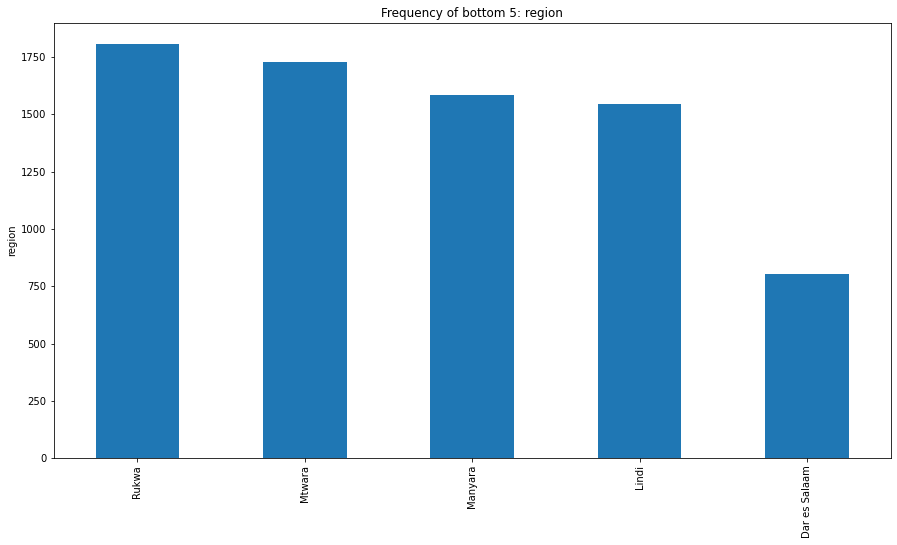

In [27]:
colInfo(df_train.region)

Prefer region. Fewer columns. More readable. Might be able to cross lookup with geojson files as well. 

**OHE** region. **Drop** region_code

### District Code

,Number,Percentage
,,
Zeroes,23,0.04 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,20,0.03 %
Mean,5.63,-
Median,3.00,-


,Value Count,% Value Count
1,12203,20.543771
2,11173,18.809764
3,9998,16.831650
4,8999,15.149832
5,4356,7.333333
6,4074,6.858586
7,3343,5.627946
8,1043,1.755892
30,995,1.675084
33,874,1.471380


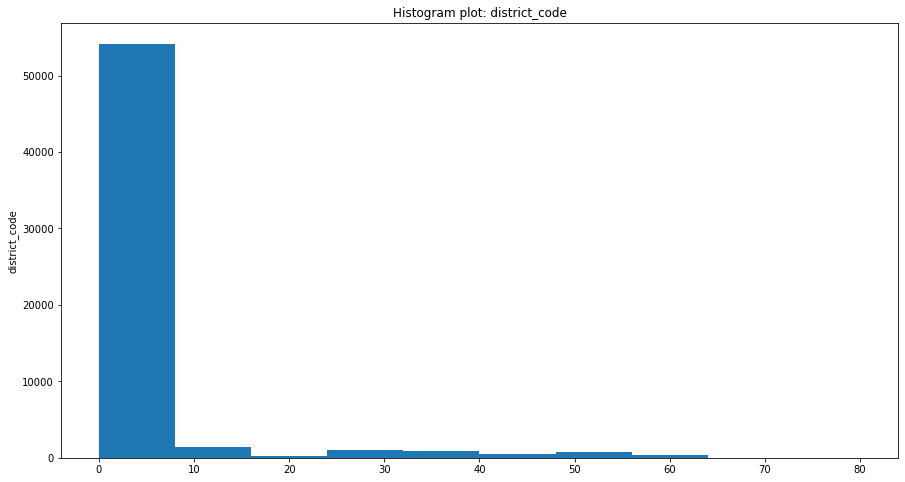

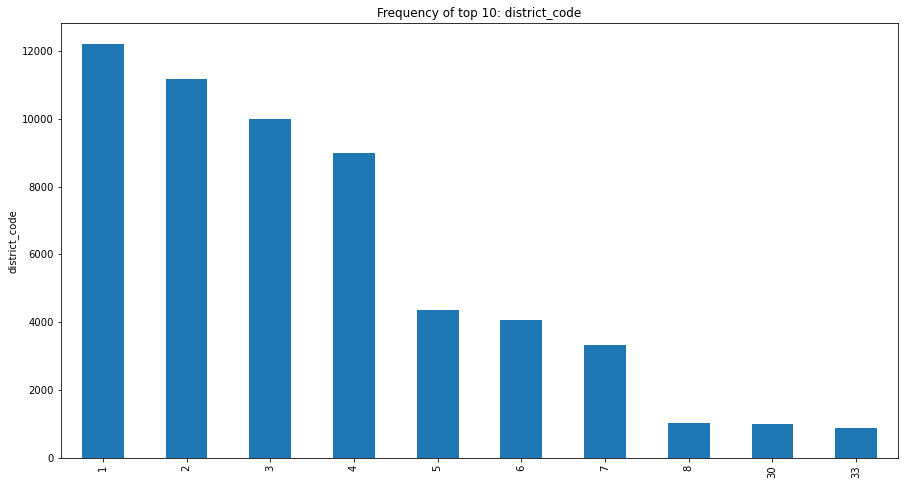

In [28]:
colInfo(df_train.district_code)

**OHE** to keep or **Drop**? Both seem fairly viable
Don't use as numerical. Although it does look like smaller the number the more frequent it is used.

### lga

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,125,0.21 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
Njombe,2503,4.213805
Arusha Rural,1252,2.107744
Moshi Rural,1251,2.106061
Bariadi,1177,1.981481
Rungwe,1106,1.861953
Kilosa,1094,1.841751
Kasulu,1047,1.762626
Mbozi,1034,1.740741
Meru,1009,1.698653
Bagamoyo,997,1.678451


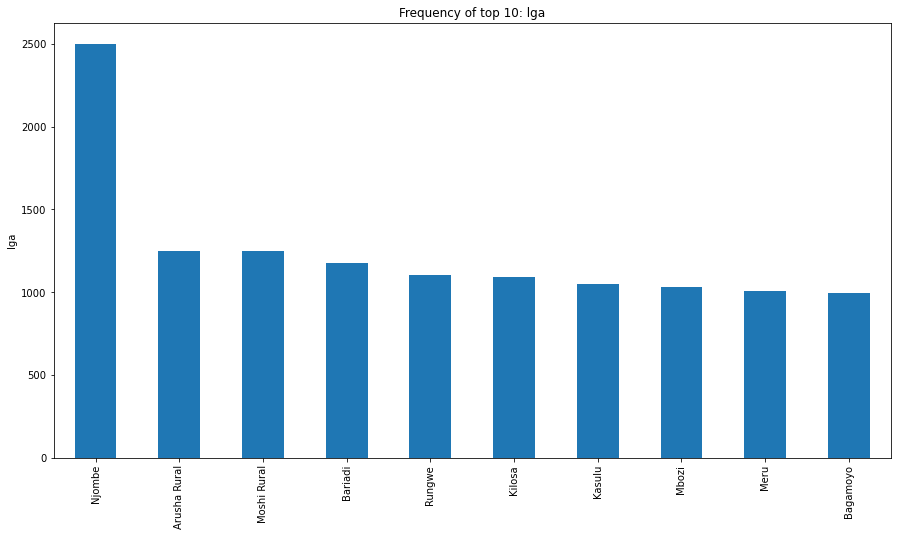

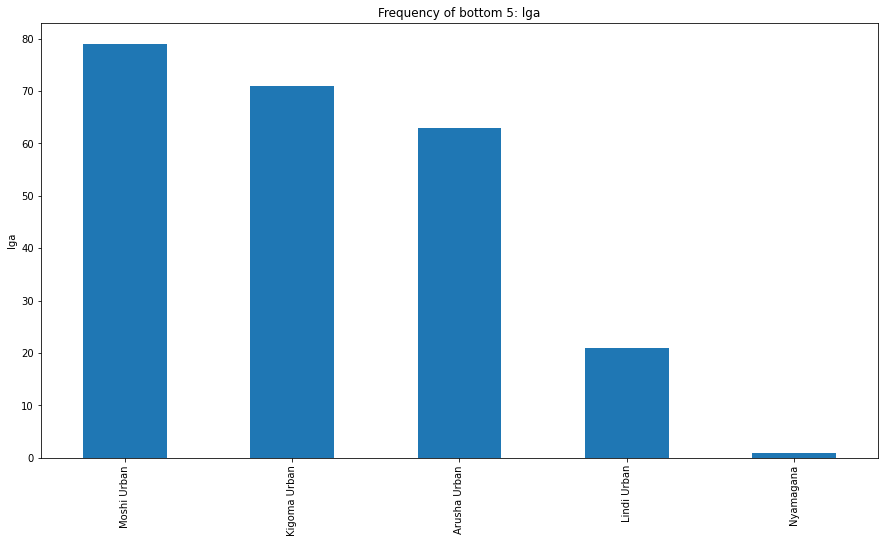

In [29]:
colInfo(df_train.lga)

125 distinct values. Not worth the extra computation after OHE. **Drop**

### ward

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,"2,092",3.52 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
Igosi,307,0.516835
Imalinyi,252,0.424242
Siha Kati,232,0.390572
Mdandu,231,0.388889
Nduruma,217,0.365320
Kitunda,203,0.341751
Mishamo,203,0.341751
Msindo,201,0.338384
Chalinze,196,0.329966
Maji ya Chai,190,0.319865


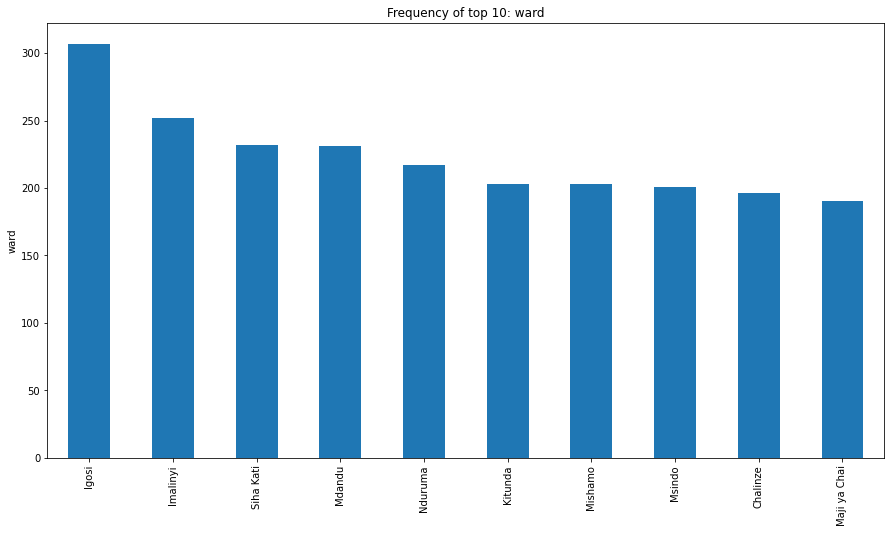

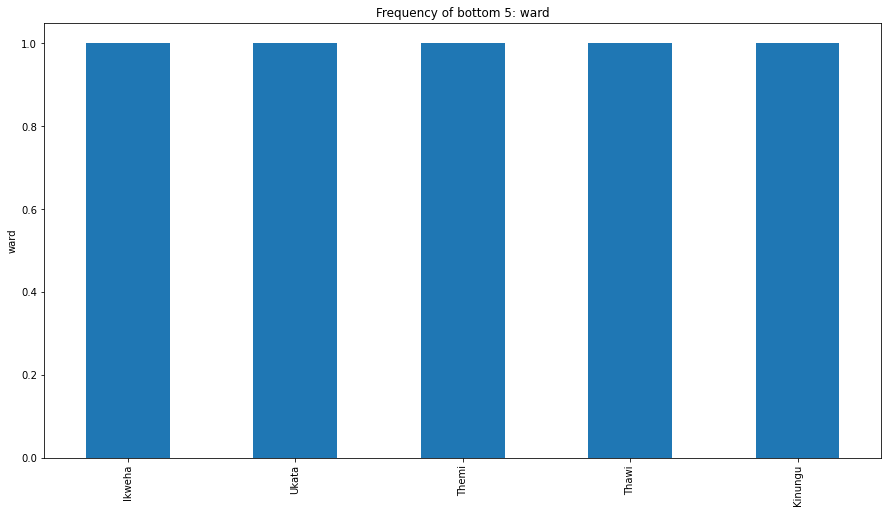

In [30]:
colInfo(df_train.ward)

2092 distinct values. Not worth the extra computation after OHE. **Drop**

### population

,Number,Percentage
,,
Zeroes,"21,381",35.99 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,"1,049",1.77 %
Mean,179.91,-
Median,25.00,-


,Value Count,% Value Count
0,21381,35.994949
1,7025,11.826599
200,1940,3.265993
150,1892,3.185185
250,1681,2.829966
300,1476,2.484848
100,1146,1.929293
50,1139,1.917508
500,1009,1.698653
350,986,1.659933


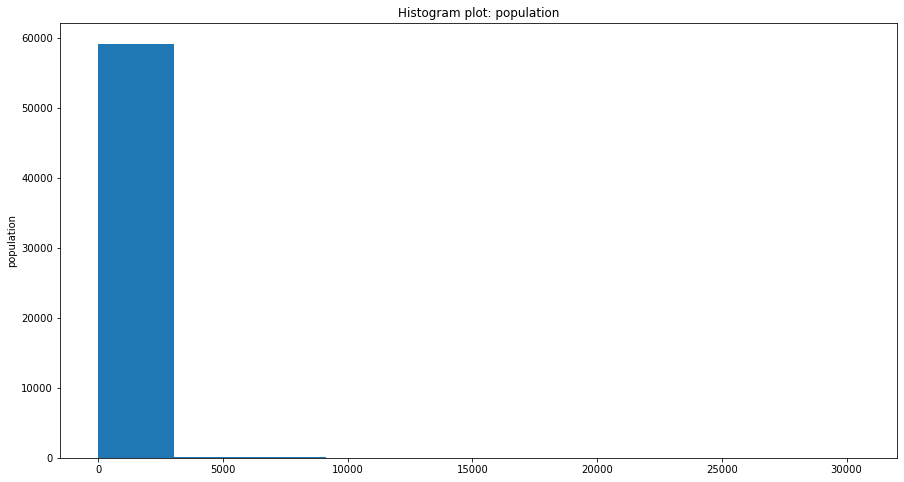

In [31]:
colInfo(df_train.population)

Nearly 36% of well water sites have a population of **0** around it?? Find that hard to believe

In [32]:
df_train.population.describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

<AxesSubplot:>

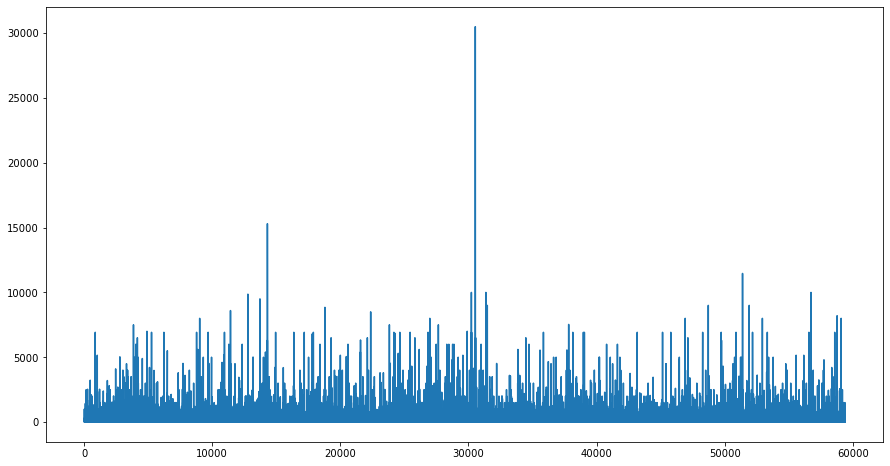

In [33]:
df_train.population.plot(kind='line',figsize=(15,8))

Not comfortable imputing zeroes (a third of our dataset) in this scenario. Plus there is always a possibility that the wells may not have a population around them.
Median = 25
Number of wells with 0 pop = 21381

If we impute in the median for these zero values

In [34]:
25*21381/df_train.population.sum()

0.050017999087272697

We'd be increasing the overall population of the entire dataset by 5%. **Drop**

### public_meeting

,Number,Percentage
,,
Zeroes,"5,055",8.51 %
Missing,"3,334",5.61 %
Unknown,0,0.00 %
Uniques,3,0.01 %
Mean,0.91,-
Median,1.00,-


,Value Count,% Value Count
True,51011,90.983840
False,5055,9.016160


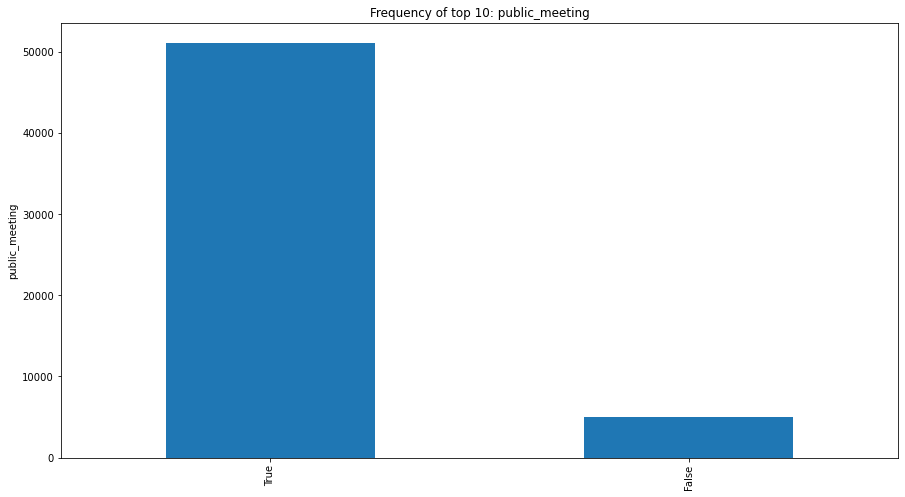

In [35]:
colInfo(df_train.public_meeting)

**Impute** nan with mode (True). Binary, no need to **OHE**

### scheme_management

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,"3,877",6.53 %
Unknown,0,0.00 %
Uniques,13,0.02 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
VWC,36793,66.266232
WUG,5206,9.376295
Water authority,3153,5.678728
WUA,2883,5.192443
Water Board,2748,4.949300
Parastatal,1680,3.025773
Private operator,1063,1.914522
Company,1061,1.910920
Other,766,1.379608
SWC,97,0.174702


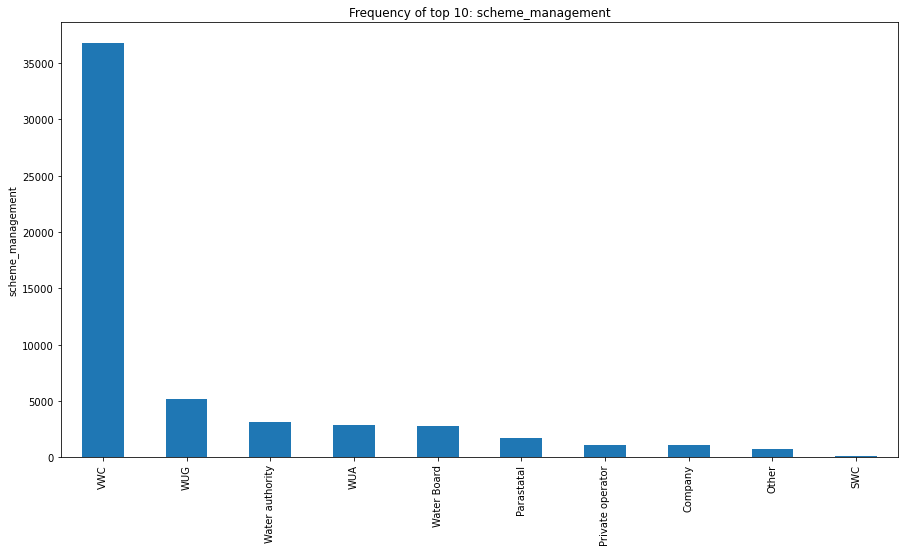

In [36]:
colInfo(df_train.scheme_management)

6.5% missing data

**Impute** with mode. **OHE**

### scheme_name

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,"28,166",47.42 %
Unknown,0,0.00 %
Uniques,"2,697",4.54 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
K,682,2.183518
None,644,2.061856
Borehole,546,1.748095
Chalinze wate,405,1.296664
M,400,1.280656
DANIDA,379,1.213421
Government,320,1.024525
Ngana water supplied scheme,270,0.864443
wanging'ombe water supply s,261,0.835628
wanging'ombe supply scheme,234,0.749184


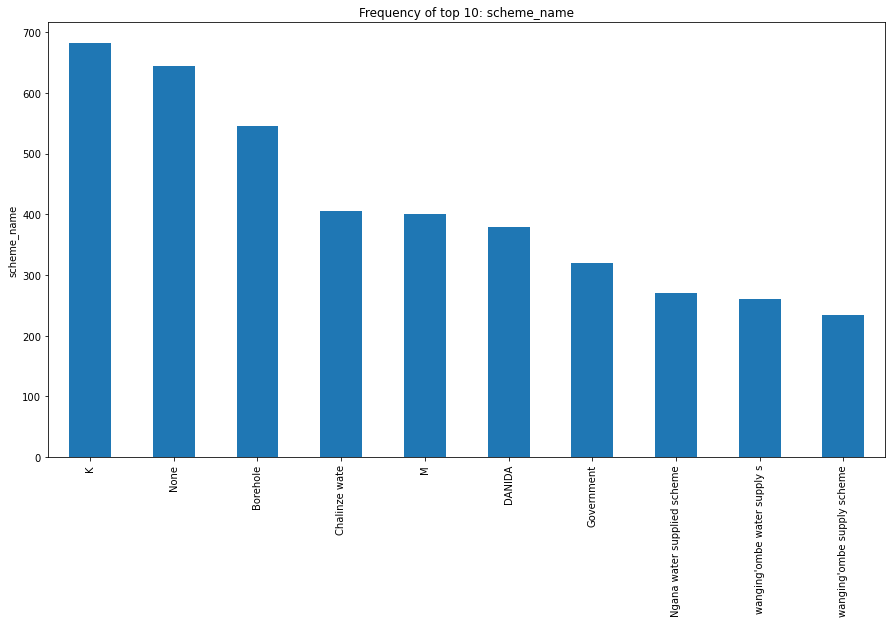

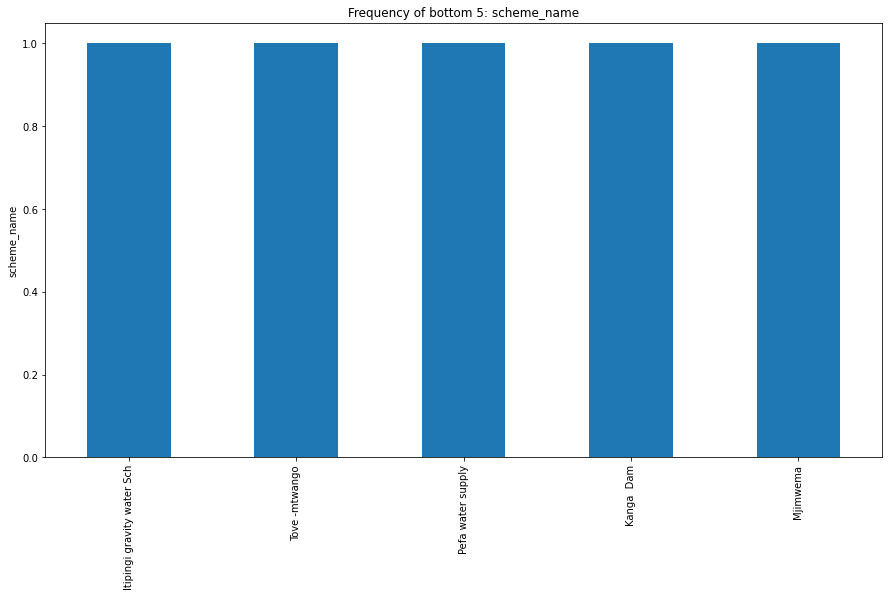

In [37]:
colInfo(df_train.scheme_name)

47% missing values and 2700 distinct labels. **Drop**

### permit

,Number,Percentage
,,
Zeroes,"17,492",29.45 %
Missing,"3,056",5.14 %
Unknown,0,0.00 %
Uniques,3,0.01 %
Mean,0.69,-
Median,1.00,-


,Value Count,% Value Count
True,38852,68.954991
False,17492,31.045009


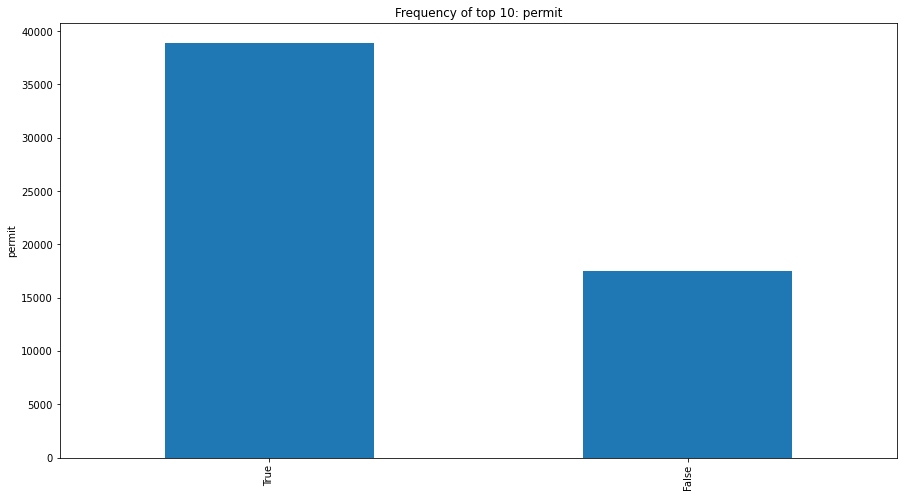

In [38]:
colInfo(df_train.permit)

5% data missing

**Impute** with mode ('True'). Binary, no need to OHE

### construction_year

,Number,Percentage
,,
Zeroes,"20,709",34.86 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,55,0.09 %
Mean,1300.65,-
Median,1986.00,-


,Value Count,% Value Count
0,20709,34.863636
2010,2645,4.452862
2008,2613,4.398990
2009,2533,4.264310
2000,2091,3.520202
2007,1587,2.671717
2006,1471,2.476431
2003,1286,2.164983
2011,1256,2.114478
2004,1123,1.890572


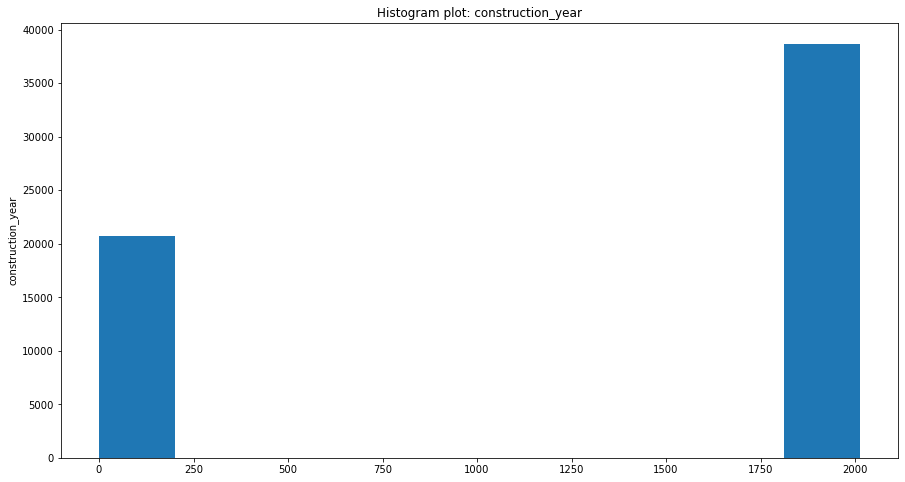

In [39]:
colInfo(df_train.construction_year)

<AxesSubplot:ylabel='Frequency'>

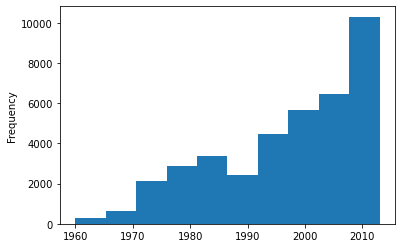

In [40]:
df_train[df_train.construction_year>0].construction_year.plot(kind='hist')

34.8% of data is filled with zeroes

In [41]:
df_train.construction_year.median()

1986.0

In [42]:
df_train[df_train.construction_year>0].construction_year.median()

2000.0

In [43]:
for year in [1960, 1970, 1980, 1990, 2000, 2010]:
    print('-'*64)
    #subset by decade
    sub = df_train[(df_train.construction_year > year) &
                   (df_train.construction_year < year+10)]
    print(f'Constructed between {year} and {year+10}: Total count {sub.shape[0]}')
    print(sub.status_group.value_counts(normalize=True))

----------------------------------------------------------------
Constructed between 1960 and 1970: Total count 436
non functional             0.614679
functional                 0.302752
functional needs repair    0.082569
Name: status_group, dtype: float64
----------------------------------------------------------------
Constructed between 1970 and 1980: Total count 3995
non functional             0.589487
functional                 0.327159
functional needs repair    0.083354
Name: status_group, dtype: float64
----------------------------------------------------------------
Constructed between 1980 and 1990: Total count 4767
non functional             0.512272
functional                 0.411580
functional needs repair    0.076149
Name: status_group, dtype: float64
----------------------------------------------------------------
Constructed between 1990 and 2000: Total count 6724
functional                 0.546252
non functional             0.385485
functional needs repair    0.068

Target statistics for homes with a construction year of zero are most similar to 1990-2000s.\
**Replace** 0 with median (2000)\
**knn** impute?

### Extraction_type, Extraction_type_group, Extraction_type_group_class

Almost identical

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,18,0.03 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
gravity,26780,45.084175
nira/tanira,8154,13.727273
other,6430,10.824916
submersible,4764,8.020202
swn 80,3670,6.178451
mono,2865,4.823232
india mark ii,2400,4.040404
afridev,1770,2.979798
ksb,1415,2.382155
other - rope pump,451,0.759259


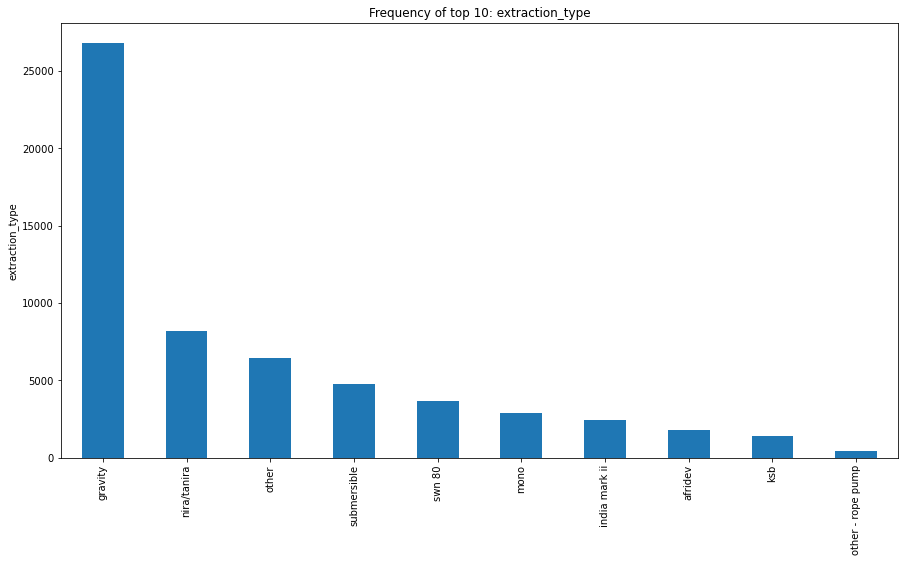

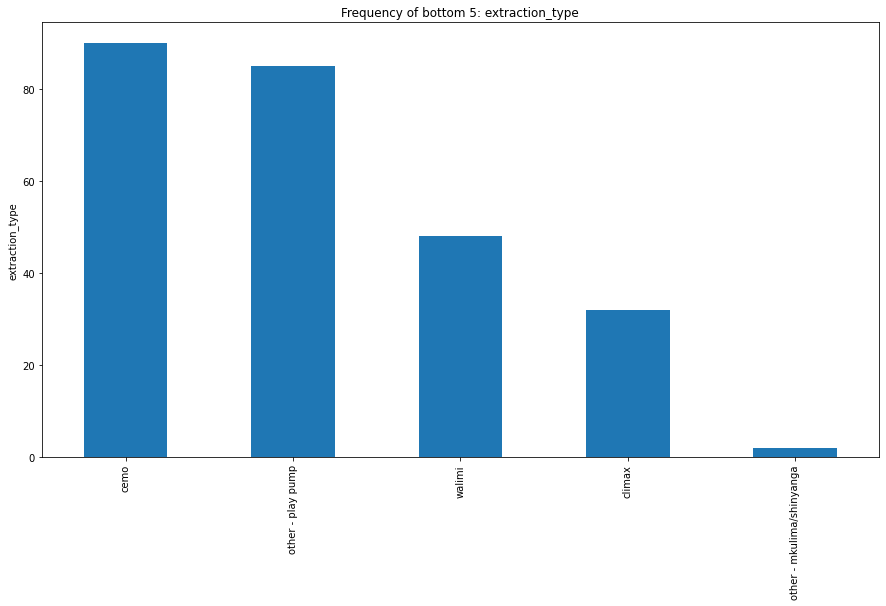

In [44]:
colInfo(df_train.extraction_type)

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,13,0.02 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
gravity,26780,45.084175
nira/tanira,8154,13.727273
other,6430,10.824916
submersible,6179,10.402357
swn 80,3670,6.178451
mono,2865,4.823232
india mark ii,2400,4.040404
afridev,1770,2.979798
rope pump,451,0.759259
other handpump,364,0.612795


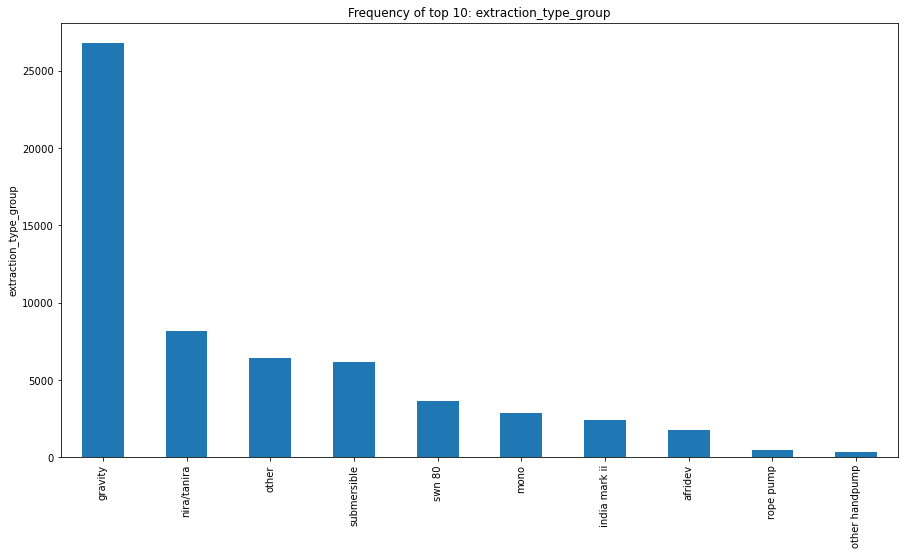

In [45]:
colInfo(df_train.extraction_type_group)

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,7,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
gravity,26780,45.084175
handpump,16456,27.703704
other,6430,10.824916
submersible,6179,10.402357
motorpump,2987,5.028620
rope pump,451,0.759259
wind-powered,117,0.196970


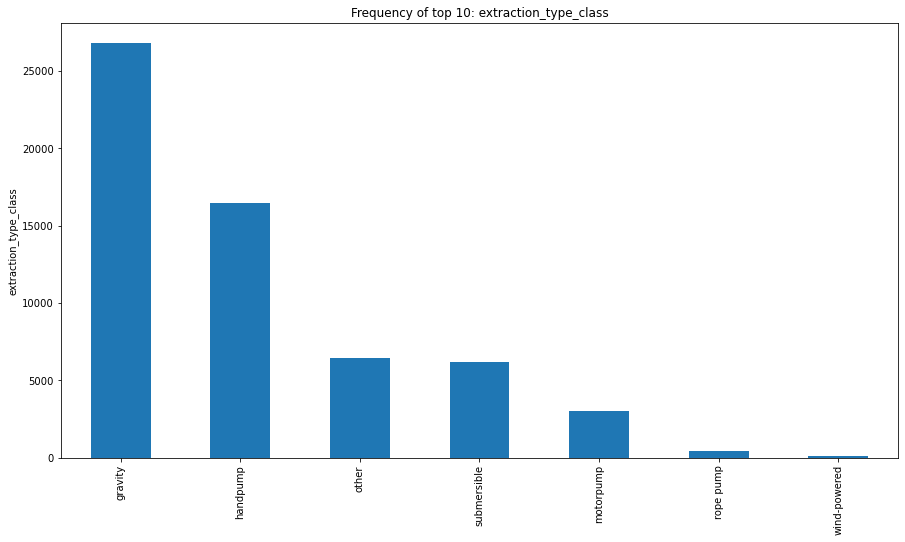

In [46]:
colInfo(df_train.extraction_type_class)

Data is a lot less skewed in the last (smallest) of these sub groups. 

**Drop** Extraction_type\
**Drop** Extraction_type_group\
**OHE** Extraction_type_class

### Management and Management Group

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,561,0.94 %
Uniques,12,0.02 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
vwc,40507,68.193603
wug,6515,10.968013
water board,2933,4.937710
wua,2535,4.267677
private operator,1971,3.318182
parastatal,1768,2.976431
water authority,904,1.521886
other,844,1.420875
company,685,1.153199
unknown,561,0.944444


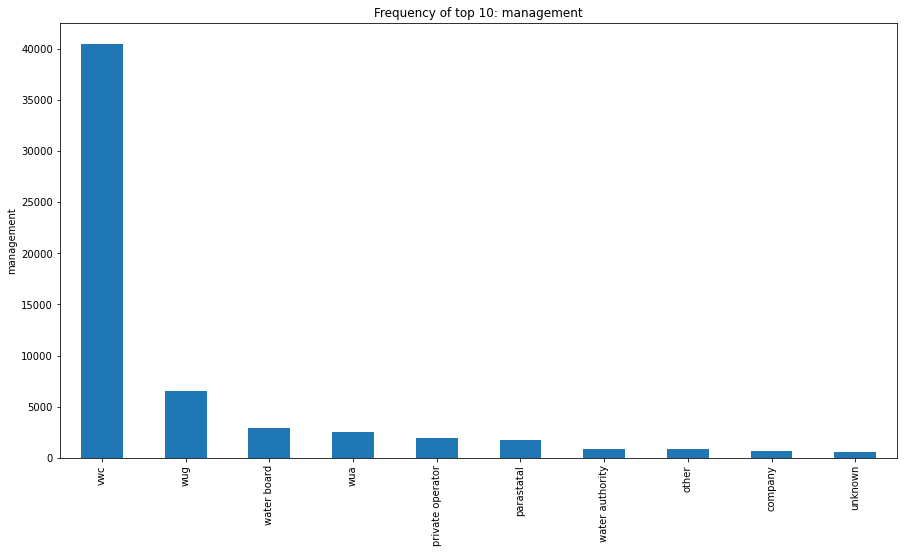

In [47]:
colInfo(df_train.management)

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,561,0.94 %
Uniques,5,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
user-group,52490,88.367003
commercial,3638,6.124579
parastatal,1768,2.976431
other,943,1.587542
unknown,561,0.944444


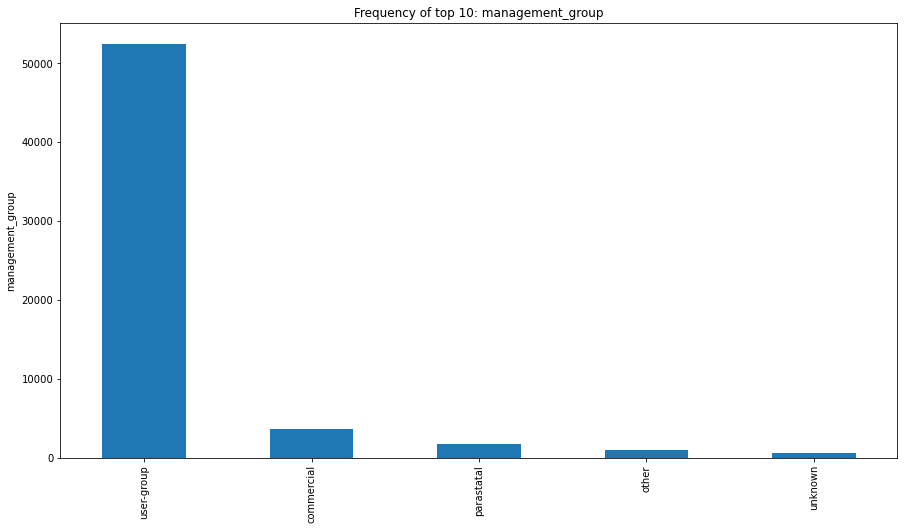

In [48]:
colInfo(df_train.management_group)

Both are pretty skewed, but former is better. 

**Drop** Management_group\
**OHE** Management

### Payment and Payment Group

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,"8,157",13.73 %
Uniques,7,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
never pay,25348,42.673401
pay per bucket,8985,15.126263
pay monthly,8300,13.973064
unknown,8157,13.732323
pay when scheme fails,3914,6.589226
pay annually,3642,6.131313
other,1054,1.774411


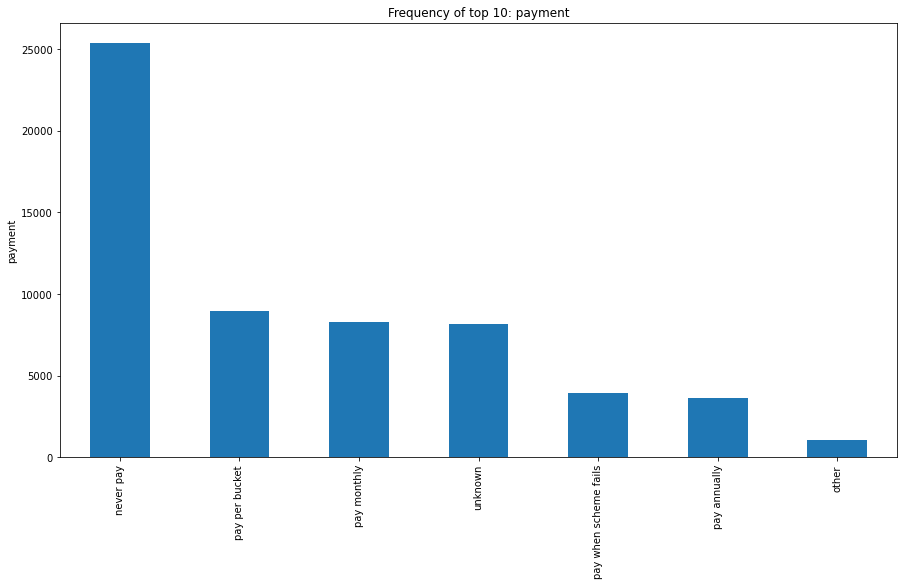

In [49]:
colInfo(df_train.payment)

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,"8,157",13.73 %
Uniques,7,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
never pay,25348,42.673401
per bucket,8985,15.126263
monthly,8300,13.973064
unknown,8157,13.732323
on failure,3914,6.589226
annually,3642,6.131313
other,1054,1.774411


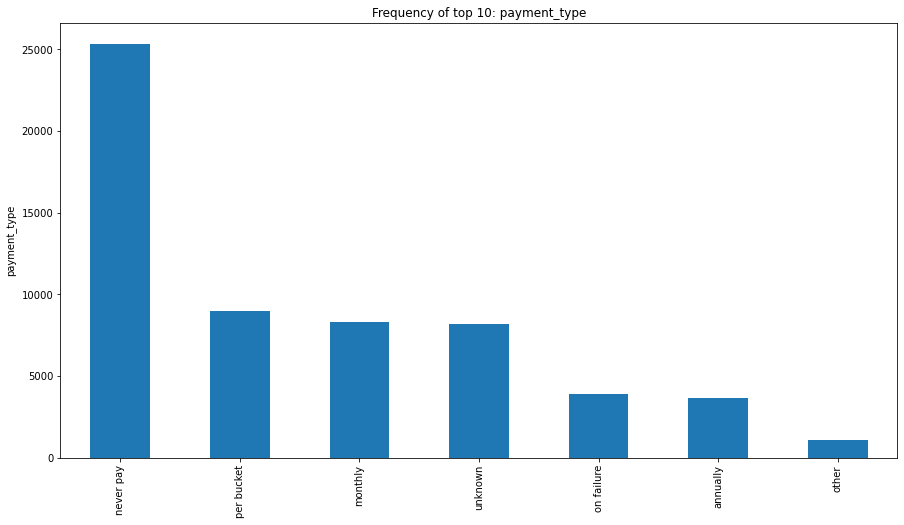

In [50]:
colInfo(df_train.payment_type)

Exactly identical. Prefer wording on first

**Drop** payment_type\
**OHE** payment

### Water Quality and Quality Group

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,"1,876",3.16 %
Uniques,8,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
soft,50818,85.552189
salty,4856,8.175084
unknown,1876,3.158249
milky,804,1.353535
coloured,490,0.824916
salty abandoned,339,0.570707
fluoride,200,0.336700
fluoride abandoned,17,0.028620


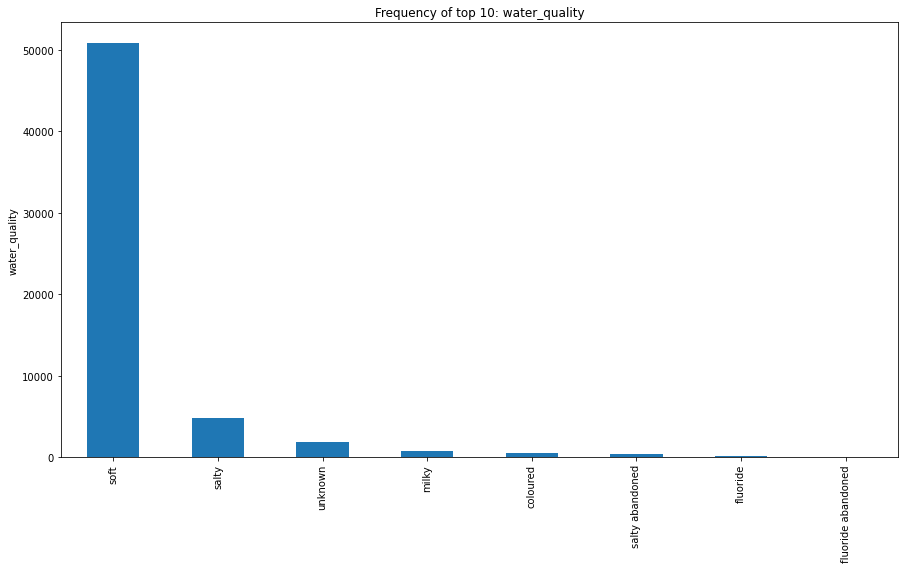

In [51]:
colInfo(df_train.water_quality)

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,"1,876",3.16 %
Uniques,6,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
good,50818,85.552189
salty,5195,8.745791
unknown,1876,3.158249
milky,804,1.353535
colored,490,0.824916
fluoride,217,0.365320


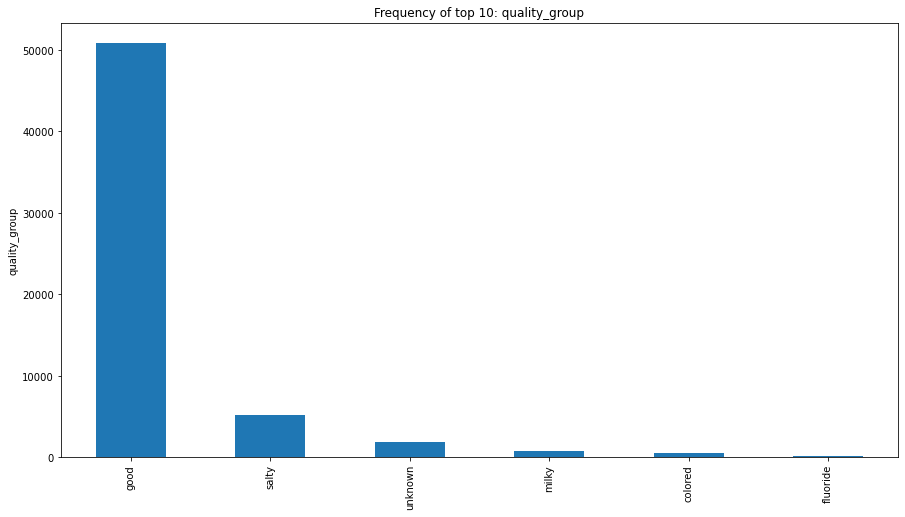

In [52]:
colInfo(df_train.quality_group)

Salty abandoned and Salty combined, fluoride and and fluoride abandoned are combined in 2nd set.

**Drop** water_quality
**OHE** quality_group

### Quantity and Quantity_group

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,789,1.33 %
Uniques,5,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
enough,33186,55.868687
insufficient,15129,25.469697
dry,6246,10.515152
seasonal,4050,6.818182
unknown,789,1.328283


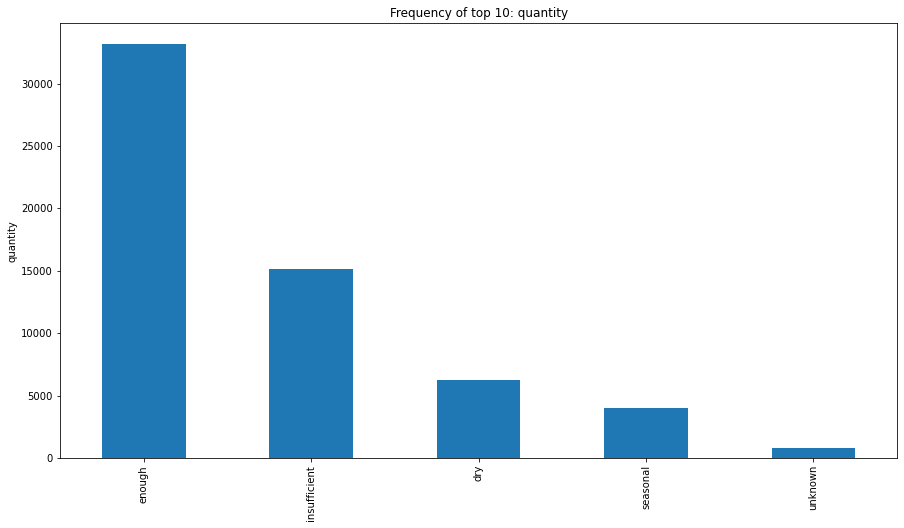

In [53]:
colInfo(df_train.quantity)

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,789,1.33 %
Uniques,5,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
enough,33186,55.868687
insufficient,15129,25.469697
dry,6246,10.515152
seasonal,4050,6.818182
unknown,789,1.328283


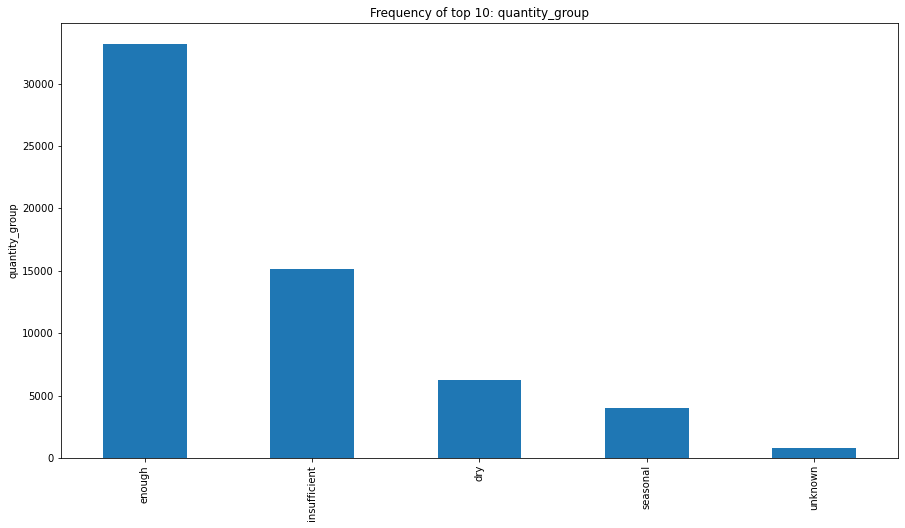

In [54]:
colInfo(df_train.quantity_group)

*Exactly* the same. 

**Drop** quantity_group
**OHE** quantity

### Source and Source_Type

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,66,0.11 %
Uniques,10,0.02 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
spring,17021,28.654882
shallow well,16824,28.323232
machine dbh,11075,18.644781
river,9612,16.181818
rainwater harvesting,2295,3.863636
hand dtw,874,1.471380
lake,765,1.287879
dam,656,1.104377
other,212,0.356902
unknown,66,0.111111


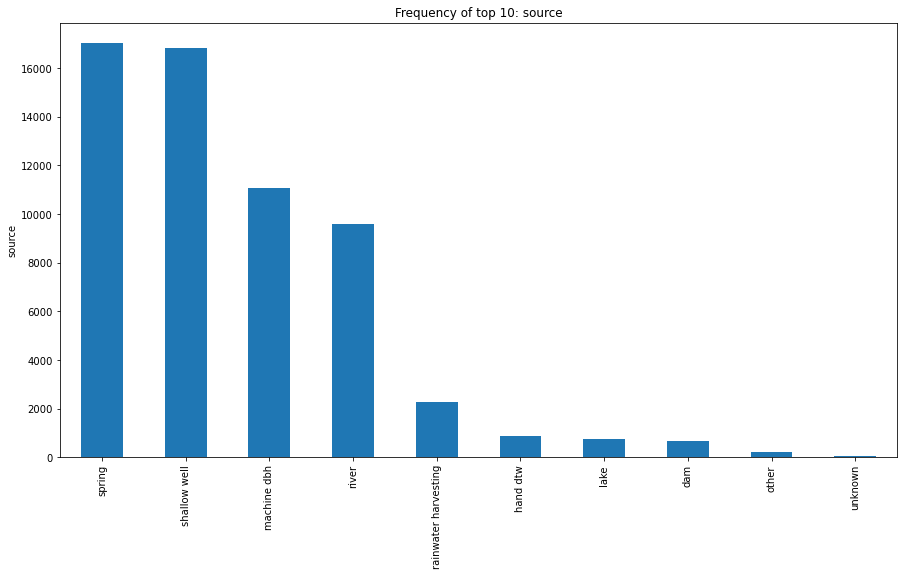

In [55]:
colInfo(df_train.source)

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,7,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
spring,17021,28.654882
shallow well,16824,28.323232
borehole,11949,20.116162
river/lake,10377,17.469697
rainwater harvesting,2295,3.863636
dam,656,1.104377
other,278,0.468013


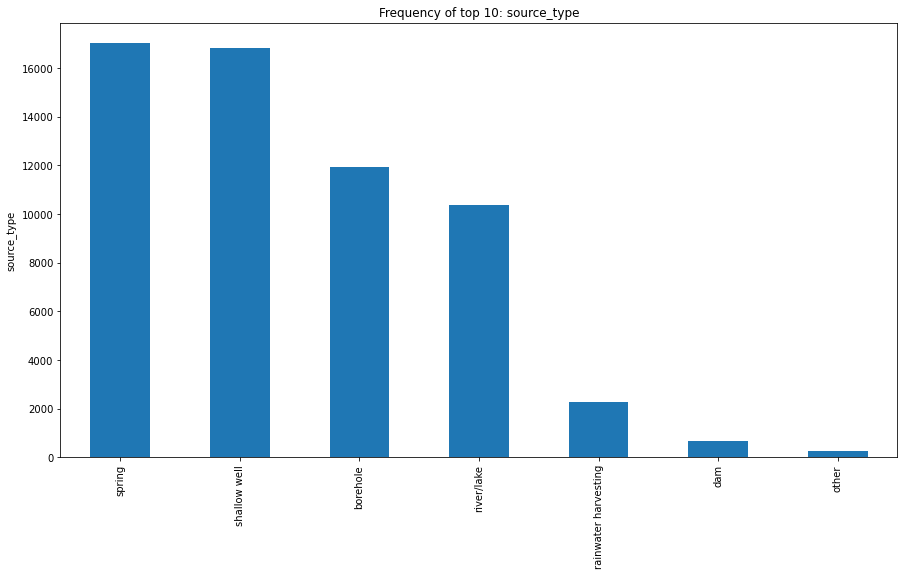

In [56]:
colInfo(df_train.source_type)

No missing values

**Drop** Source
**OHE** Source_type

### Source Class

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,278,0.47 %
Uniques,3,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
groundwater,45794,77.094276
surface,13328,22.437710
unknown,278,0.468013


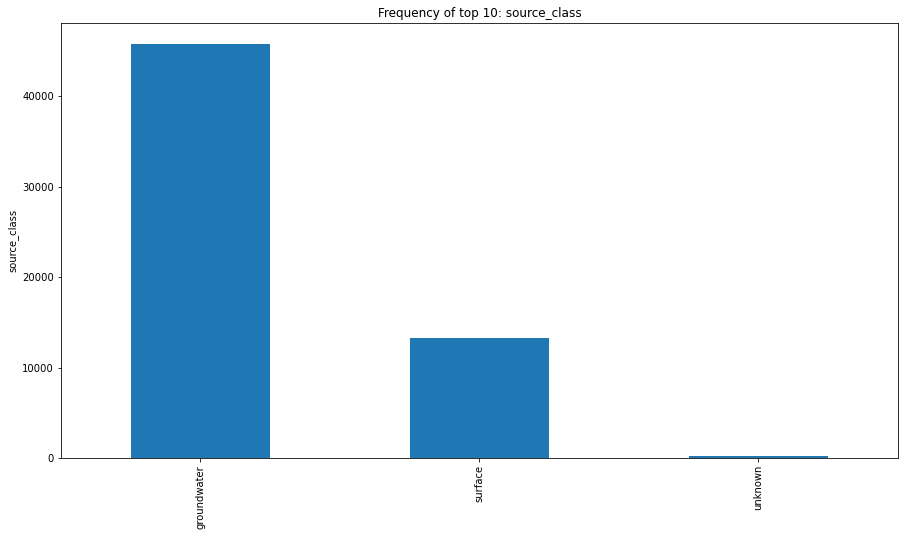

In [57]:
colInfo(df_train.source_class)

'unknown' comprises less than 0.5% of the dataset. \
**Impute** with mode. \
**OHE** to get binary column

### waterpoint_type and waterpoint_type_group

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,7,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
communal standpipe,28522,48.016835
hand pump,17488,29.441077
other,6380,10.740741
communal standpipe multiple,6103,10.274411
improved spring,784,1.319865
cattle trough,116,0.195286
dam,7,0.011785


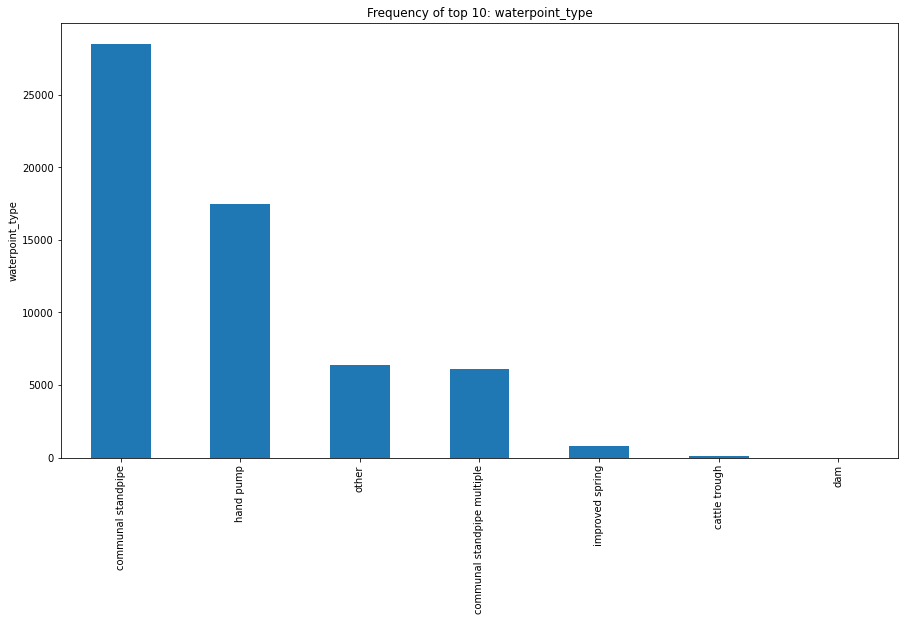

In [58]:
colInfo(df_train.waterpoint_type)

,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,6,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
communal standpipe,34625,58.291246
hand pump,17488,29.441077
other,6380,10.740741
improved spring,784,1.319865
cattle trough,116,0.195286
dam,7,0.011785


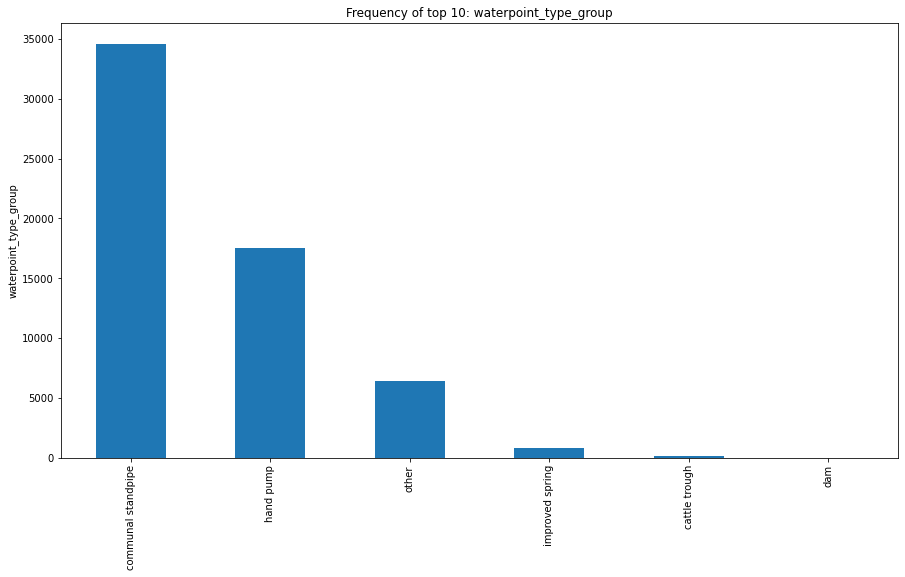

In [59]:
colInfo(df_train.waterpoint_type_group)

Fairly similar, with the second combing communal standpipe and communal standpipe multiple.

**Drop** waterpoint_type
**OHE** waterpoint_type_group